# Wines Points prediction 

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Import libraries

First, we are going to import all the libraries needed for our project.

In [2]:
import pandas as pd
import numpy as np
import cufflinks as cf; cf.go_offline()

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import string
import re as regex

In [25]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the data

Then, read the csv file.

In [7]:
data_r = pd.read_csv("data/winemag-data-130k-v2.csv") # r = raw

## Explanatory Data Analysis

In this section we will analyze and investigate our dataset and summarize its main characteristics. This analysis can help identify obvious errors, as well as better understand patterns within the data, detect outliers or anomalous events, find interesting relations among the variables.

In [8]:
data_r.shape

(129971, 14)

In [9]:
data_r.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

**Meaning of each column:**

**1) country:** The country that the wine is from.

**2) description:** A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.

**3) designation:** The vineyard within the winery where the grapes that made the wine are from.

**4) points:** The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)

**5) price:** The cost for a bottle of the wine.

**6) province:** The province or state that the wine is from.

**7) region_1:** The wine growing area in a province or state (ie Napa).

**8) region_2:** Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank.

**9) variety:** The type of grapes used to make the wine (ie Pinot Noir).

**10) winery:** The winery that made the wine

In [10]:
data_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [11]:
data_r.sample(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
108096,108096,Spain,Stalky aromas of shrubs and bushes blend with ...,Xibrana Crianza,86,15.0,Catalonia,Priorat,NaN,Michael Schachner,@wineschach,Vicente Gandia 2013 Xibrana Crianza Red (Priorat),Red Blend,Vicente Gandia
122606,122606,Italy,"Aromas of yellow pear, Spanish broom and a whi...",Ab Vinea Doni,89,21.0,Tuscany,Vernaccia di San Gimignano,NaN,Kerin O’Keefe,@kerinokeefe,Falchini 2015 Ab Vinea Doni (Vernaccia di San...,White Blend,Falchini


Columns 'Unnamed: 0' and 'taster_twitter_handle' don't seem to add any valuable information. Therefore, we will drop them. But first we will create a "working" dataset.

In [12]:
data_w = data_r.copy() # w = working

In [13]:
data_w.drop(['Unnamed: 0','taster_twitter_handle'], axis = 1, inplace = True)
data_w.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [14]:
data_w.shape

(129971, 12)

Search for missing, NA and null values.

In [15]:
(data_w.isnull() | data_w.empty | data_w.isna()).sum()

country           63
description        0
designation    37465
points             0
price           8996
province          63
region_1       21247
region_2       79460
taster_name    26244
title              0
variety            1
winery             0
dtype: int64

As it can be seen above only a small number of countries names are missing (63/129971 ~ 0.05%). We can see also that only for one row the variety is null. Therefore we will remove those entries from the data.

In [16]:
data_w = data_w.dropna(subset=['country','variety'])
data_w.shape

(129907, 12)

In [17]:
(data_w.isnull() | data_w.empty | data_w.isna()).sum()

country            0
description        0
designation    37453
points             0
price           8992
province           0
region_1       21183
region_2       79396
taster_name    26243
title              0
variety            0
winery             0
dtype: int64

Now we will check unique values for each of the features in our data.

In [18]:
data_w.nunique()

country            43
description    119895
designation     37954
points             21
price             390
province          425
region_1         1229
region_2           17
taster_name        19
title          118780
variety           701
winery          16745
dtype: int64

In [19]:
check_duplicates = data_w[data_w.duplicated('description', keep = False)].sort_values('description')
check_duplicates.shape

(20018, 12)

We would expect the description to be unique. Anyway we see that there duplicates. Therefore we will investigate some examples in order to understand the data.

In [20]:
check_duplicates.tail(4)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery
129801,Italy,"“Il Bugiardo,” which is Italian for “the liar,...",Il Bugiardo,88,36.0,Veneto,Valpolicella Classico Superiore Ripasso,NaN,NaN,Buglioni 2009 Il Bugiardo (Valpolicella Class...,"Corvina, Rondinella, Molinara",Buglioni
87891,Italy,"“Il Bugiardo,” which is Italian for “the liar,...",Il Bugiardo,88,36.0,Veneto,Valpolicella Classico Superiore Ripasso,NaN,NaN,Buglioni 2009 Il Bugiardo (Valpolicella Class...,"Corvina, Rondinella, Molinara",Buglioni
19401,Canada,"“Open and drink” the instructions should read,...",NaN,89,20.0,British Columbia,Okanagan Valley,NaN,Paul Gregutt,Quails' Gate 2012 Chardonnay (Okanagan Valley),Chardonnay,Quails' Gate
91976,Canada,"“Open and drink” the instructions should read,...",NaN,89,20.0,British Columbia,Okanagan Valley,NaN,Paul Gregutt,Quails' Gate 2012 Chardonnay (Okanagan Valley),Chardonnay,Quails' Gate


In the above examples it can be seen that there are duplicates that can distort our conclusions. Possible actions: remove?

In [21]:
data_w.drop_duplicates("description").shape

(119895, 12)

In [22]:
(data_w.isnull() | data_w.empty | data_w.isna()).sum()

country            0
description        0
designation    37453
points             0
price           8992
province           0
region_1       21183
region_2       79396
taster_name    26243
title              0
variety            0
winery             0
dtype: int64

We can see that there are empty price rows in our data. We will fill them with the average price.

In [23]:
data_w['price'] = data_w['price'].fillna(data_w['price'].mean())

In [24]:
(data_w.isnull() | data_w.empty | data_w.isna()).sum() #just to check that price column is complete

country            0
description        0
designation    37453
points             0
price              0
province           0
region_1       21183
region_2       79396
taster_name    26243
title              0
variety            0
winery             0
dtype: int64

Next we will try to understand  some basic statistical details like percentile, mean and std regarding our numerical features.

In [25]:
stats = round(data_w[['points','price']].describe(),1)
stats

,points,price
count,129907.0,129907.0
mean,88.4,35.4
std,3.0,39.6
min,80.0,4.0
25%,86.0,18.0
50%,88.0,28.0
75%,91.0,40.0
max,100.0,3300.0


We will summarize our conclusions as follows:
- the are rows with missing points but with price
- the volatility of price is higher than price. We can see this from the standard deviation value. The range for points varies from 80 to 100 but for price varies from 4 to 3300!!!
- there aren't negative values whichs seems to be correct
- following the last point, there could be outliers in the price feature. We will try to check this further in the following graph.

Text(0.5, 1.0, 'Boxplot of price column')

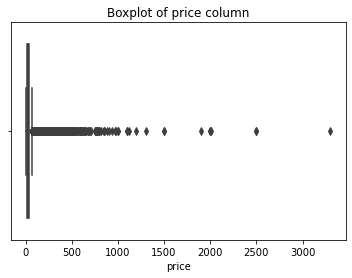

In [26]:
sns.boxplot(data=data_w,x=data_w["price"])
plt.title("Boxplot of price column")

From the plot above we can identify some strong outliers that can potentially affect our prediction. We will check how many outliers of this sort there are.

In [27]:
data_w.query('price >= 1000').count()

country        16
description    16
designation     3
points         16
price          16
province       16
region_1       14
region_2        1
taster_name    16
title          16
variety        16
winery         16
dtype: int64

So there are only 16 high price products. We will "sacrify", ie remove, these entries in order to prevent distortions in tour prediction.

In [28]:
data_f = data_w.query('price < 1000') # f = final
data_f.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.368796,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


Text(0.5, 1.0, 'Boxplot of price column')

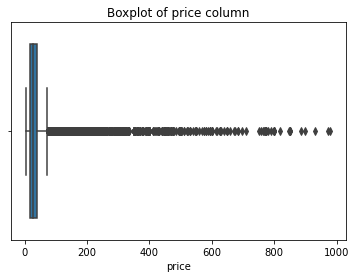

In [29]:
sns.boxplot(data=data_f,x=data_f["price"])
plt.title("Boxplot of price column")

We will try to understand the distribution of our data using visualization tools.

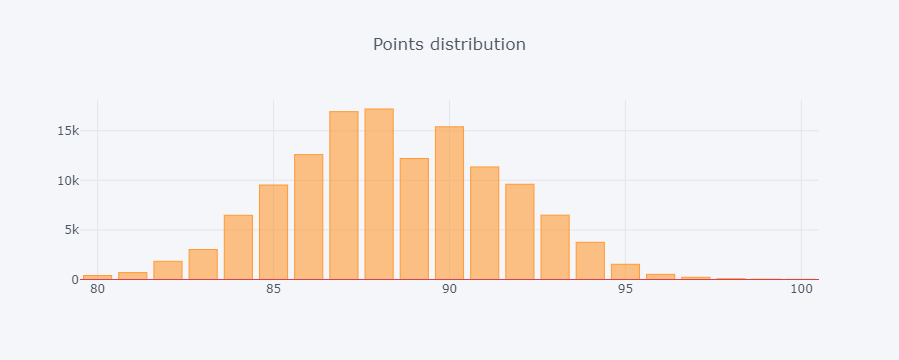

In [30]:
data_f.points.value_counts().iplot(kind='bar', title = 'Points distribution', hline=(0))

It can be concluded that the points column roughly moves from 80 to 100 points.

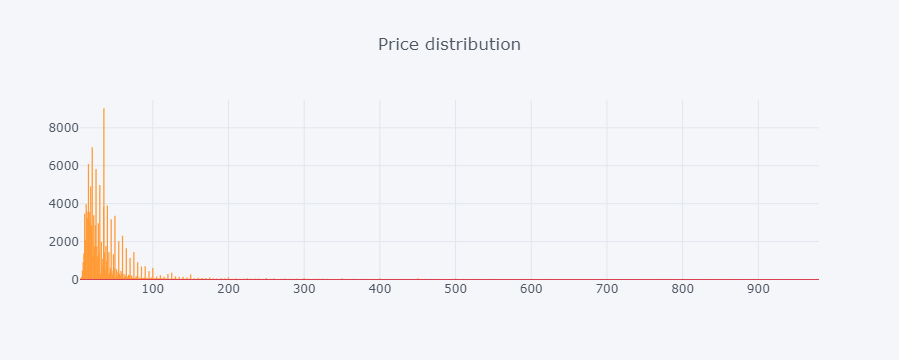

In [31]:
data_f.price.value_counts().iplot(kind='bar', title = 'Price distribution', hline=(0))

In the following section we will analyze the distribution of the data by country.

In [32]:
countries_dist = round(data_f.country.value_counts().div(data_f.shape[0]),6)*100
countries_dist

US                        41.9606
France                    16.9989
Italy                     15.0434
Spain                      5.1158
Portugal                   4.3806
Chile                      3.4421
Argentina                  2.9255
Austria                    2.5745
Australia                  1.7930
Germany                    1.6668
New Zealand                1.0925
South Africa               1.0786
Israel                     0.3888
Greece                     0.3588
Canada                     0.1979
Hungary                    0.1124
Bulgaria                   0.1086
Romania                    0.0924
Uruguay                    0.0839
Turkey                     0.0693
Slovenia                   0.0670
Georgia                    0.0662
England                    0.0570
Croatia                    0.0562
Mexico                     0.0539
Moldova                    0.0454
Brazil                     0.0400
Lebanon                    0.0269
Morocco                    0.0216
Peru          

In [33]:
def calc_average_score_and_price(country_df):
    return pd.Series({'count': country_df.country.count(),
                      'average_price': round(country_df.price.mean(),2),
                      'min_price': country_df.price.min(),
                      'max_price': country_df.price.max(),                        
                      'average_score': round(country_df.points.mean(),2),
                       'min_score': country_df.points.min(),
                      'max_score': country_df.points.max()}
                    )

In [34]:
stats_by_country = data_f.groupby('country').apply(calc_average_score_and_price).reset_index()
stats_by_country.sort_values('count', ascending=False).head()

,country,count,average_price,min_price,max_price,average_score,min_score,max_score
40,US,54503.0,36.53,4.0,750.0,88.56,80.0,100.0
15,France,22080.0,39.00,5.0,973.0,88.84,80.0,100.0
22,Italy,19540.0,39.09,5.0,900.0,88.56,80.0,100.0
37,Spain,6645.0,28.29,4.0,770.0,87.29,80.0,98.0
31,Portugal,5690.0,27.36,5.0,980.0,88.25,80.0,100.0


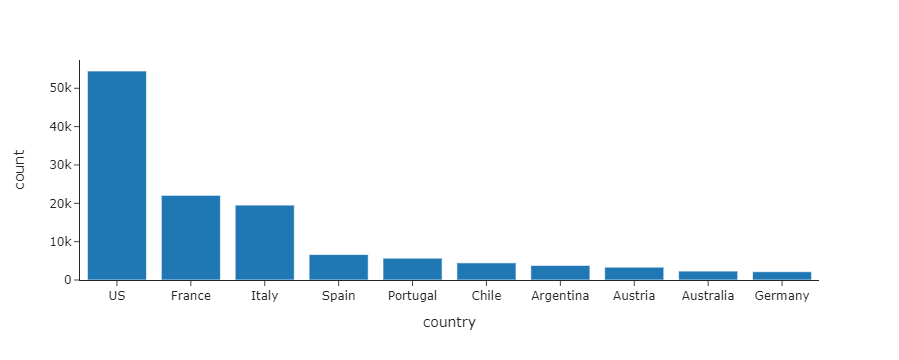

In [35]:
country_top = data_f.groupby('country').size().reset_index(name='count').sort_values('count', ascending=False)
px.bar(country_top.head(10), x='country', y='count', template='simple_white')

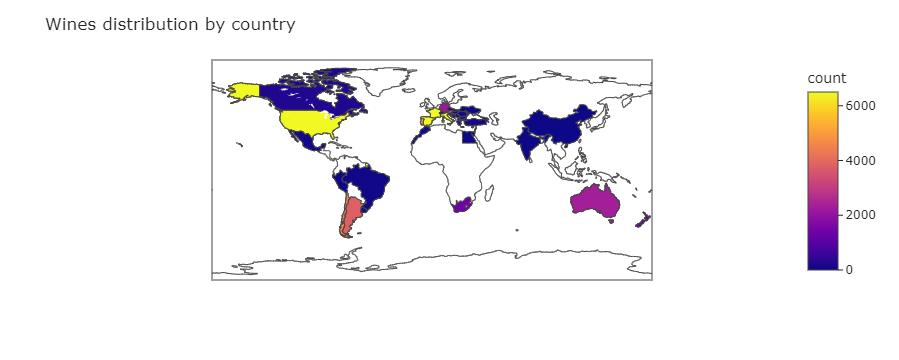

In [36]:
fig = px.choropleth(country_top, locations = 'country', locationmode='country names', color = 'count', template = 'simple_white',range_color=[0,6500],
              color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title_text = 'Wines distribution by country')

fig.show()

## Points prediction

Points is a discrete value target. Therefore we are talking about a prediction (Regression) problem (contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [37]:
train_data = data_f.sample(frac = 0.8)
test_data = data_f[~data_f.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(data_f))

In [38]:
len(test_data), len(train_data)

(25978, 103913)

### Baselines

In [39]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [40]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.364946
MAE    2.504136
R2    -0.000035
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [41]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.658537
Armenia                   87.500000
Australia                 88.589662
Austria                   90.122380
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [42]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    8.950475
MAE    2.445987
R2     0.044225
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [43]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.767782
           Other               86.002309
Armenia    Armenia             87.500000
Australia  Australia Other     85.519417
           New South Wales     87.438356
Name: basiline_3_predicted_points, dtype: float64

In [44]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((25978, 15), (25978, 14))

In [45]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.426780
MAE    2.356449
R2     0.100147
dtype: float64

### Baselines summary

In [46]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.364946,2.504136,-0.000035
baseline_2,8.950475,2.445987,0.044225
baseline_3,8.426780,2.356449,0.100147


## Training a Boosting trees regressor

#### Preparing data - Lable encoding categorical features

In [47]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery'] #need to be encoded
numerical_features = ['price'] #not need to be encoded, already expressed in numerical terms
features = categorical_features + numerical_features

In [48]:
encoded_features = data_f[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = data_f.price
encoded_features['points'] = data_f.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,331,424,6,9,684,11602,35.368796,87
1,31,108,738,6,16,447,12949,15.000000,87
2,40,268,1218,17,15,433,13011,14.000000,87
3,40,218,549,6,0,476,14380,13.000000,87
4,40,268,1218,17,15,437,14610,65.000000,87


#### Re-splitting to train and test

In [49]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(data_f))

#### Fitting a tree-regressor

In [50]:
from src.models import i_feel_lucky_xgboost_training

In [51]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103913 entries, 1 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      103913 non-null  int32  
 1   province     103913 non-null  int32  
 2   region_1     103913 non-null  int32  
 3   region_2     103913 non-null  int32  
 4   taster_name  103913 non-null  int32  
 5   variety      103913 non-null  int32  
 6   winery       103913 non-null  int32  
 7   price        103913 non-null  float64
 8   points       103913 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 5.2 MB


In [52]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [53]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
0,22,331,424,6,9,684,11602,35.368796,87,89
2,40,268,1218,17,15,433,13011,14.000000,87,87
8,17,307,738,6,1,209,8412,12.000000,87,87
13,22,331,424,6,9,386,10813,35.368796,87,89
15,17,232,738,6,1,476,13229,24.000000,87,90


In [54]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.158211
MAE    1.876742
R2     0.342396
dtype: float64

In [55]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.364946,2.504136,-0.000035
baseline_2,8.950475,2.445987,0.044225
baseline_3,8.426780,2.356449,0.100147
regression_by_xgb,6.158211,1.876742,0.342396


In [56]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

Import libraries

In [57]:
from src.clean_text import leave_language_only

In [58]:
from sklearn.metrics import accuracy_score

Create a new 'description_clean" column.

In [59]:
data_f['description_clean'] = leave_language_only(data_f.description.str.lower())
data_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129891 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   country            129891 non-null  object 
 1   description        129891 non-null  object 
 2   designation        92451 non-null   object 
 3   points             129891 non-null  int64  
 4   price              129891 non-null  float64
 5   province           129891 non-null  object 
 6   region_1           108710 non-null  object 
 7   region_2           50510 non-null   object 
 8   taster_name        103648 non-null  object 
 9   title              129891 non-null  object 
 10  variety            129891 non-null  object 
 11  winery             129891 non-null  object 
 12  description_clean  129891 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


There are words in the original description columns that occur frequently but they do not provide any additional or valuable information to the text containing them. Words like a, they, the, is, an, etc. are usually considered **stop words** and we are going to remove them.

In [63]:
stopwords = nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish") + nltk.corpus.stopwords.words("french")

In [64]:
data_f['description_clean'] = data_f['description_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [65]:
word_freq = pd.Series(' '.join(data_f['description_clean']).split()).value_counts()[:30]
word_freq

wine          77978
flavors       62629
fruit         44996
aromas        39573
palate        38051
acidity       34934
finish        34905
tannins       30828
drink         29946
cherry        27349
ripe          26976
black         25364
notes         19011
red           18847
spice         18776
rich          17262
fresh         16942
nose          16896
oak           16644
berry         15482
dry           15438
plum          14107
soft          13533
fruits        13494
blend         13046
apple         12823
crisp         12783
blackberry    12693
offers        12654
sweet         12395
dtype: int64

From the query above it can be seen that there are a number of words with high frequency that don't add any value to our analysis. Therefore, we will add these words to our stopwords list and we will repeat the previous process.

In [66]:
stopwords.append('wine')

In [67]:
stopwords.append('flavors')

In [68]:
stopwords.append('drink')

In [69]:
data_f['description_clean'] = data_f['description_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [70]:
word_freq = pd.Series(' '.join(data_f['description_clean']).split()).value_counts()[:30]
word_freq

fruit         44996
aromas        39573
palate        38051
acidity       34934
finish        34905
tannins       30828
cherry        27349
ripe          26976
black         25364
notes         19011
red           18847
spice         18776
rich          17262
fresh         16942
nose          16896
oak           16644
berry         15482
dry           15438
plum          14107
soft          13533
fruits        13494
blend         13046
apple         12823
crisp         12783
blackberry    12693
offers        12654
sweet         12395
texture       12382
white         12299
shows         11507
dtype: int64

Now we will show the word description frequency visually.

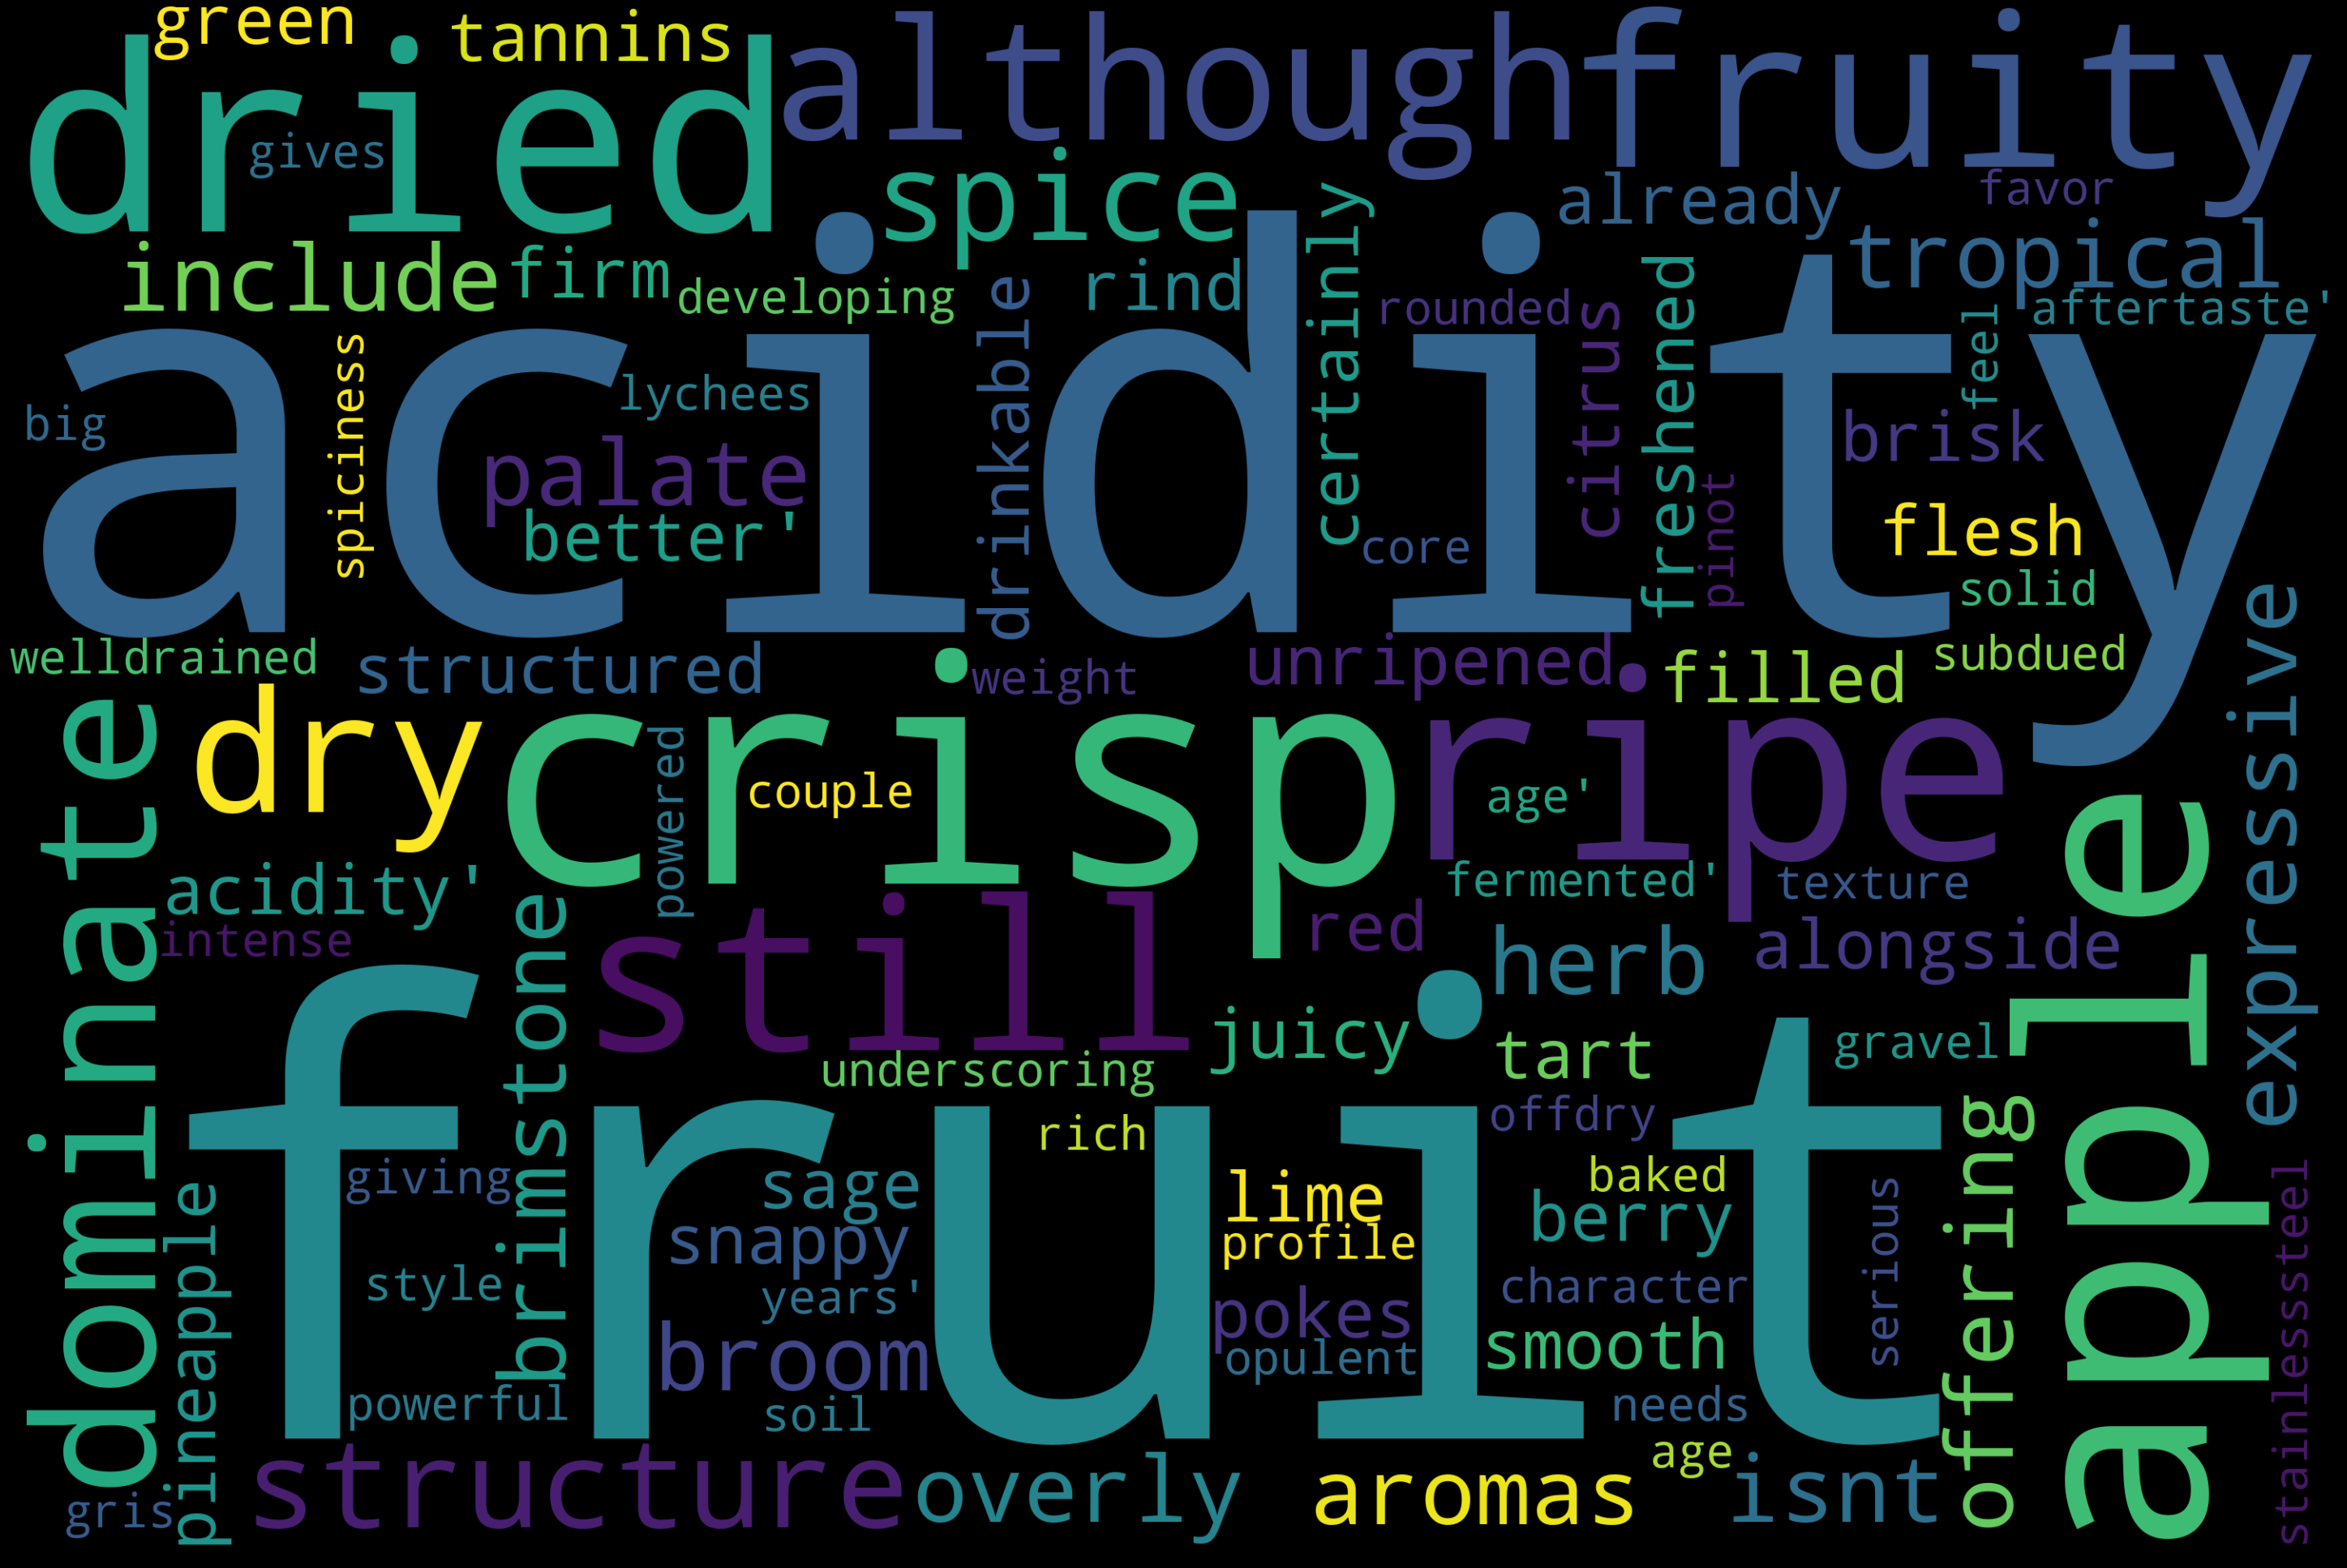

In [293]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = data_f.description_clean.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In the next code we will build our vocabulary.

In [72]:
all_words = [word for text in data_f.description_clean for word in nltk.word_tokenize(text)] # Words without stop words

words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,fruit,44996,0.000022
1,aromas,39573,0.000025
2,palate,38051,0.000026
3,acidity,34934,0.000028
4,finish,34905,0.000028


In [86]:
words_df[words_df['word'].str.contains('frui')]

,word,wordCount,wordImportance
0,fruit,44996,0.000022
20,fruits,13494,0.000073
40,fruity,9464,0.000105
137,grapefruit,4057,0.000244
248,fruitiness,2452,0.000404
...,...,...,...
44218,redfruitcrisp,1,0.989577
44292,stonefruitdriven,1,0.989577
44396,fruit—primary,1,0.989577
44438,fruit—equally,1,0.989577


**Note** - It should be considered to stemm our vocabulary in order to reduce the inflection in words to their root forms.

We will choose only words that appear more than 5 times.

In [73]:
vocab = set(words_df[words_df.wordCount >= 5].word)

In [74]:
count_vect = CountVectorizer(vocabulary = vocab, tokenizer=nltk.word_tokenize)
bow_counts = count_vect.fit_transform(data_f.description_clean)
bow_counts.shape

(129891, 13587)

In [75]:
x, y = bow_counts, data_f['points'] 

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2 ,random_state=100)

In [77]:
model_linear = LinearRegression()
model_linear.fit(x_train, y_train)

LinearRegression()

In [78]:
nlp_desc_prediction = model_linear.predict(x_test)
nlp_desc_prediction

array([88.66774939, 88.07915233, 83.50317678, ..., 92.48934783,
       90.47989757, 90.45934243])

In [79]:
y_test_array = np.array(y_test.values.tolist())
y_test_array

array([92, 89, 84, ..., 90, 89, 88])

In [80]:
classic_nlp_df = pd.DataFrame(nlp_desc_prediction,columns=['prediction'])
classic_nlp_df

,prediction
0,88.667749
1,88.079152
2,83.503177
3,88.112006
4,91.214191
...,...
25974,90.164465
25975,92.932713
25976,92.489348
25977,90.479898


In [81]:
classic_nlp_df['true_value'] = y_test_array.tolist()
classic_nlp_df

,prediction,true_value
0,88.667749,92
1,88.079152,89
2,83.503177,84
3,88.112006,89
4,91.214191,92
...,...,...
25974,90.164465,91
25975,92.932713,88
25976,92.489348,90
25977,90.479898,89


In [82]:
nlp_stats = calc_prediction_quality(classic_nlp_df, 'prediction', 'true_value')
nlp_stats

MSE    3.165062
MAE    1.390200
R2     0.656971
dtype: float64

In [83]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,nlp_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','nlp'])
all_compared

,MSE,MAE,R2
baseline_1,9.364946,2.504136,-0.000035
baseline_2,8.950475,2.445987,0.044225
baseline_3,8.426780,2.356449,0.100147
regression_by_xgb,6.158211,1.876742,0.342396
nlp,3.165062,1.390200,0.656971


In [84]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Using both the text and other features

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

In [85]:
from scipy.sparse import coo_matrix, hstack

In [86]:
other_features = encoded_features.iloc[:,:-1]
other_features.head(1)

,country,province,region_1,region_2,taster_name,variety,winery,price
0,22,331,424,6,9,684,11602,35.368796


In [87]:
encoded_features_spares_matrix = coo_matrix(other_features)

In [88]:
united_features = hstack((bow_counts, encoded_features_spares_matrix))

In [89]:
x_all, y_all = united_features, encoded_features['points'] 

In [90]:
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(x_all, y_all, test_size=0.2 ,random_state=100)

In [91]:
model_linear_all = LinearRegression()
model_linear_all.fit(x_train_all, y_train_all)

LinearRegression()

In [92]:
nlp_all_prediction = model_linear_all.predict(x_test_all)
nlp_all_prediction

array([88.97904695, 88.16642781, 83.41929033, ..., 92.49088099,
       90.21736498, 90.19609211])

In [93]:
y_test_all_array = np.array(y_test_all.values.tolist())
y_test_all_array

array([92, 89, 84, ..., 90, 89, 88])

In [94]:
classic_nlp_all_df = pd.DataFrame(nlp_all_prediction,columns=['prediction'])
classic_nlp_all_df

,prediction
0,88.979047
1,88.166428
2,83.419290
3,88.476458
4,90.948123
...,...
25974,89.836639
25975,92.800056
25976,92.490881
25977,90.217365


In [95]:
classic_nlp_all_df['true_value'] = y_test_all_array.tolist()
classic_nlp_all_df

,prediction,true_value
0,88.979047,92
1,88.166428,89
2,83.419290,84
3,88.476458,89
4,90.948123,92
...,...,...
25974,89.836639,91
25975,92.800056,88
25976,92.490881,90
25977,90.217365,89


In [96]:
nlp_all_stats = calc_prediction_quality(classic_nlp_all_df, 'prediction', 'true_value')
nlp_all_stats

MSE    2.911302
MAE    1.328500
R2     0.684474
dtype: float64

In [97]:
all_compared = round(pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, nlp_stats, nlp_all_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','nlp','nlp_all'])
, 5)
all_compared

,MSE,MAE,R2
baseline_1,9.36495,2.50414,-0.00003
baseline_2,8.95047,2.44599,0.04422
baseline_3,8.42678,2.35645,0.10015
regression_by_xgb,6.15821,1.87674,0.34240
nlp,3.16506,1.39020,0.65697
nlp_all,2.91130,1.32850,0.68447


**Conclusion** - Taking into account all the features of the data does improve the results.

In [ ]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Deep Learning approaches

### Fully connected network on the text only

#### Tokenization

In [98]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [99]:
train_clean_data = data_f.sample(frac = 0.8)
test_clean_data = data_f[~data_f.index.isin(train_clean_data.index)]
assert(len(train_data) + len(test_data) == len(data_f))

What is a good size for the vocabulary? 

In [100]:
data_f.description_clean.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    35.0
0.99    41.0
Name: description_clean, dtype: float64

In [101]:
vocab_size = 32000 # This is an hyperparameter, experiment with different values
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [102]:
vectorize_layer.adapt(train_clean_data['description_clean'])

In [103]:
sample_description = train_clean_data['description_clean'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

barrel fermented aged onceused french oak offers generous aromas corn cob corn silk baked apple spice silky restrained showing lovely sense balance


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([ 185,  543,  276, 5582,  285,   17,   27,  171,    3, 1672, 9942,
       1672, 2520,  179,   24,   13,  206,  480,  163,  287,  339,   83,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int64)>

In [104]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

185 --->  barrel
543 --->  fermented
276 --->  aged
5582 --->  onceused
285 --->  french
17 --->  oak
27 --->  offers
171 --->  generous
3 --->  aromas
1672 --->  corn
9942 --->  cob
1672 --->  corn
2520 --->  silk
179 --->  baked
24 --->  apple
13 --->  spice
206 --->  silky
480 --->  restrained
163 --->  showing
287 --->  lovely


#### Modeling

In [105]:
embedding_dim=16

dnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [106]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

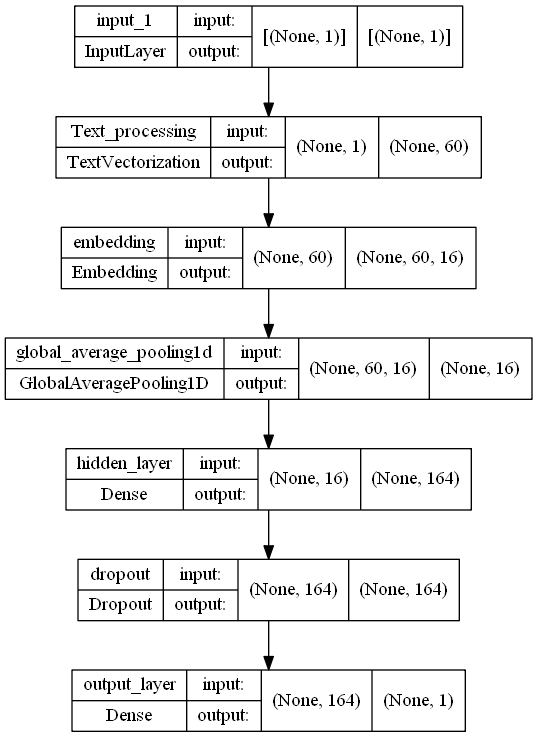

In [107]:
tf.keras.utils.plot_model(dnn_model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [108]:
dnn_model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [135]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = dnn_model.fit(
    train_clean_data[text_col],
    train_clean_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_clean_data[text_col], test_clean_data[target_col]))

Epoch 1/20
812/812 [==============================] - 12s 14ms/step - loss: 2.9083 - mean_squared_error: 13.3138 - mean_absolute_error: 2.9083 - val_loss: 1.3620 - val_mean_squared_error: 2.9657 - val_mean_absolute_error: 1.3620
Epoch 2/20
812/812 [==============================] - 11s 14ms/step - loss: 2.8952 - mean_squared_error: 13.1926 - mean_absolute_error: 2.8952 - val_loss: 1.3687 - val_mean_squared_error: 3.0055 - val_mean_absolute_error: 1.3687
Epoch 3/20
812/812 [==============================] - 11s 14ms/step - loss: 2.8850 - mean_squared_error: 13.1370 - mean_absolute_error: 2.8850 - val_loss: 1.3780 - val_mean_squared_error: 3.0392 - val_mean_absolute_error: 1.3780
CPU times: total: 1min 23s
Wall time: 34.3 s


### Simple NN Prediction & Evaluation

In [136]:
test_clean_data['dnn_prediction'] = dnn_model.predict(test_clean_data[text_col])

In [137]:
dnn_stats = calc_prediction_quality(test_clean_data, 'dnn_prediction', target_col)
dnn_stats

MSE    2.965652
MAE    1.362010
R2     0.680461
dtype: float64

In [138]:
all_compared = round(pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, nlp_stats, nlp_all_stats, dnn_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','nlp', 'nlp_all', 'dnn']), 5)
all_compared

,MSE,MAE,R2
baseline_1,9.36495,2.50414,-0.00003
baseline_2,8.95047,2.44599,0.04422
baseline_3,8.42678,2.35645,0.10015
regression_by_xgb,6.15821,1.87674,0.34240
nlp,3.16506,1.39020,0.65697
nlp_all,2.91130,1.32850,0.68447
dnn,2.96565,1.36201,0.68046


In [ ]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Descriptions words concatinated

In [126]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding
from tensorflow.keras import Sequential

In [127]:
embedding_dim=16

concat_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding", ),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [128]:
concat_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 concat_words (Reshape)      (None, 960)               0         
                                                                 
 hidden_layer (Dense)        (None, 164)               157604    
                                                                 
 dropout_2 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 165       
                                                      

In [129]:
concat_model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

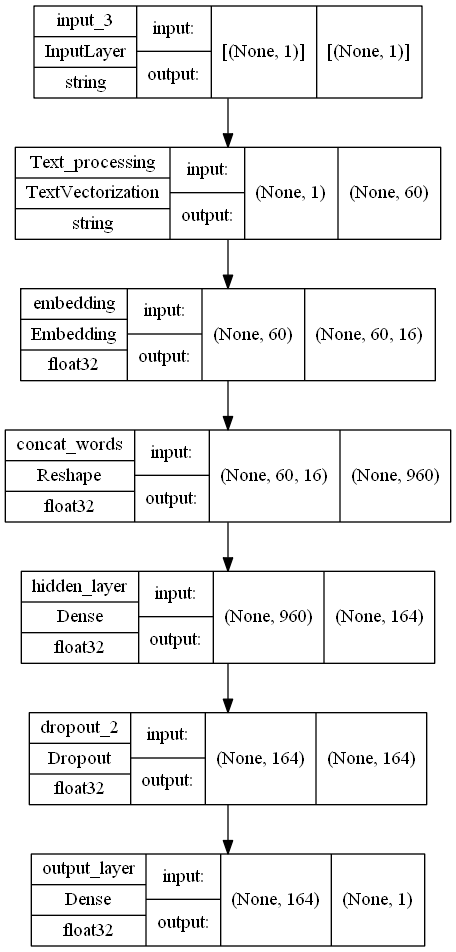

In [130]:
tf.keras.utils.plot_model(concat_model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [131]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = concat_model.fit(
    train_clean_data[text_col],
    train_clean_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_clean_data[text_col], test_clean_data[target_col]))

Epoch 1/20
812/812 [==============================] - 13s 16ms/step - loss: 20.3468 - mean_squared_error: 959.8979 - mean_absolute_error: 20.3468 - val_loss: 2.4861 - val_mean_squared_error: 9.3043 - val_mean_absolute_error: 2.4861
Epoch 2/20
812/812 [==============================] - 13s 16ms/step - loss: 3.6872 - mean_squared_error: 21.2120 - mean_absolute_error: 3.6872 - val_loss: 2.4723 - val_mean_squared_error: 9.3772 - val_mean_absolute_error: 2.4723
Epoch 3/20
812/812 [==============================] - 12s 15ms/step - loss: 3.6871 - mean_squared_error: 21.2256 - mean_absolute_error: 3.6871 - val_loss: 2.4880 - val_mean_squared_error: 9.2838 - val_mean_absolute_error: 2.4880
Epoch 4/20
812/812 [==============================] - 12s 15ms/step - loss: 3.6837 - mean_squared_error: 21.1674 - mean_absolute_error: 3.6837 - val_loss: 1.8913 - val_mean_squared_error: 5.6524 - val_mean_absolute_error: 1.8913
Epoch 5/20
812/812 [==============================] - 12s 15ms/step - loss: 3.174

In [139]:
test_clean_data['concat_prediction'] = concat_model.predict(test_clean_data[text_col])

In [140]:
concat_stats = calc_prediction_quality(test_clean_data, 'concat_prediction', target_col)
concat_stats

MSE    3.096587
MAE    1.394272
R2     0.666353
dtype: float64

In [142]:
all_compared = round(pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, nlp_stats, nlp_all_stats, dnn_stats, concat_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','nlp', 'nlp_all', 'dnn','dnn_concat']),5)
all_compared

,MSE,MAE,R2
baseline_1,9.36495,2.50414,-0.00003
baseline_2,8.95047,2.44599,0.04422
baseline_3,8.42678,2.35645,0.10015
regression_by_xgb,6.15821,1.87674,0.34240
nlp,3.16506,1.39020,0.65697
nlp_all,2.91130,1.32850,0.68447
dnn,2.96565,1.36201,0.68046
dnn_concat,3.09659,1.39427,0.66635


**Conclusion** - this model improves the results. This is, it seems that there is importance in the order of the words (no good <> good no).

In [143]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Using external embedding (description feature only)

Follow https://keras.io/examples/nlp/pretrained_word_embeddings/

You can either average the description words embeddings, concatinate them or do both and compare. 

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

The Keras Embedding layer can also use a word embedding learned elsewhere.

In [169]:
f = open("pretrained_embeddings/glove.6B.100d.txt", encoding = "utf8")

In [170]:
embeddings_index = {}
for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [162]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [172]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19408 words (12592 misses)


In [179]:
num_tokens

32002

In [178]:
len(word_index) + 1

32001

In [199]:
from tensorflow import keras
#from tensorflow.keras.layers import Embedding
from keras.layers import Dense, Embedding, Input, Activation, Dropout, GlobalAveragePooling1D

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


In [203]:
embedding_layer = Embedding(num_tokens, embedding_dim, weights = [embedding_matrix], trainable = False) 
int_sequences_input  = Input(shape=(1,), dtype=tf.string)
vec_layer = vectorize_layer(int_sequences_input )
embedded_sequences = embedding_layer(vec_layer) 
x = GlobalAveragePooling1D()(embedded_sequences)
x = Dense(164, activation = 'relu')(x)
x = Dropout(0.1)(x)
output = Dense(1)(x)

In [206]:
pretrained_emb_model = keras.Model(inputs=int_sequences_input, outputs=output)

In [210]:
pretrained_emb_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 1)]               0         
                                                                 
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding_10 (Embedding)    (None, 60, 100)           3200200   
                                                                 
 global_average_pooling1d_11  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense (Dense)               (None, 164)               16564     
                                                                 
 dropout_14 (Dropout)        (None, 164)               0     

In [211]:
pretrained_emb_model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

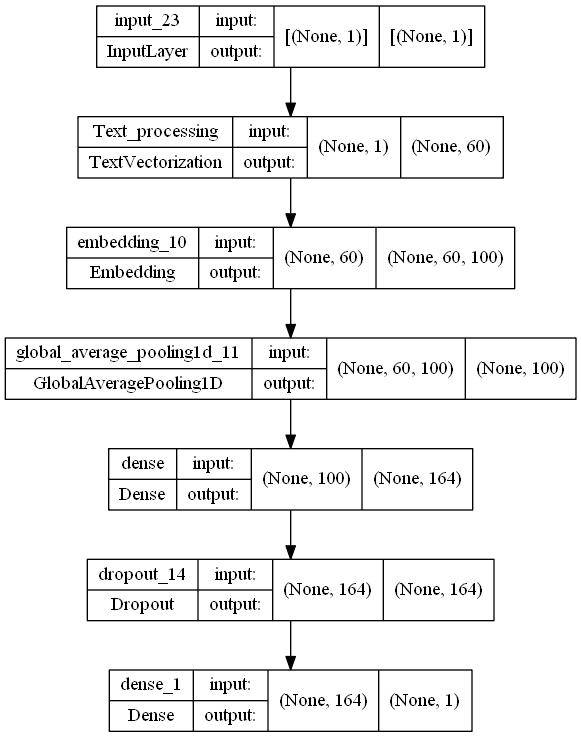

In [212]:
tf.keras.utils.plot_model(pretrained_emb_model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [213]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = pretrained_emb_model.fit(
    train_clean_data[text_col],
    train_clean_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_clean_data[text_col], test_clean_data[target_col]))

Epoch 1/20
812/812 [==============================] - 7s 8ms/step - loss: 27.2569 - mean_squared_error: 1424.3811 - mean_absolute_error: 27.2569 - val_loss: 12.2770 - val_mean_squared_error: 237.8413 - val_mean_absolute_error: 12.2770
Epoch 2/20
812/812 [==============================] - 7s 8ms/step - loss: 8.8222 - mean_squared_error: 132.6299 - mean_absolute_error: 8.8222 - val_loss: 3.6876 - val_mean_squared_error: 21.4109 - val_mean_absolute_error: 3.6876
Epoch 3/20
812/812 [==============================] - 6s 8ms/step - loss: 3.3206 - mean_squared_error: 17.6784 - mean_absolute_error: 3.3206 - val_loss: 1.8000 - val_mean_squared_error: 5.1439 - val_mean_absolute_error: 1.8000
Epoch 4/20
812/812 [==============================] - 6s 8ms/step - loss: 3.0884 - mean_squared_error: 15.0574 - mean_absolute_error: 3.0884 - val_loss: 1.7919 - val_mean_squared_error: 5.1450 - val_mean_absolute_error: 1.7919
Epoch 5/20
812/812 [==============================] - 7s 9ms/step - loss: 3.0617 -

In [214]:
test_clean_data['ext_emb_prediction'] = pretrained_emb_model.predict(test_clean_data[text_col])

In [215]:
ext_emb_stats = calc_prediction_quality(test_clean_data, 'ext_emb_prediction', target_col)
ext_emb_stats

MSE    4.791881
MAE    1.737383
R2     0.483691
dtype: float64

In [217]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, nlp_stats, nlp_all_stats, dnn_stats, concat_stats, ext_emb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','nlp', 'all_nlp', 'dnn', 'dnn_concat','pre_trained_emb'])
all_compared

,MSE,MAE,R2
baseline_1,9.364946,2.504136,-0.000035
baseline_2,8.950475,2.445987,0.044225
baseline_3,8.426780,2.356449,0.100147
regression_by_xgb,6.158211,1.876742,0.342396
nlp,3.165062,1.390200,0.656971
all_nlp,2.911302,1.328500,0.684474
dnn,2.965652,1.362010,0.680461
dnn_concat,3.096587,1.394272,0.666353
pre_trained_emb,4.791881,1.737383,0.483691


In [218]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Using LSTM or RNN Layer, (description feature only)

See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

In [219]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras import Sequential

In [242]:
embedding_dim=16
units=160

lstm_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding", ),
    LSTM(units),
    Dense(164, activation='relu', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [243]:
lstm_model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [244]:
lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 lstm_4 (LSTM)               (None, 160)               113280    
                                                                 
 hidden_layer (Dense)        (None, 164)               26404     
                                                                 
 dropout_19 (Dropout)        (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 165       
                                                     

In [245]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = lstm_model.fit(
    train_clean_data[text_col],
    train_clean_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_clean_data[text_col], test_clean_data[target_col]))

Epoch 1/20
812/812 [==============================] - 142s 171ms/step - loss: 8.3361 - mean_squared_error: 271.0793 - mean_absolute_error: 8.3361 - val_loss: 2.6512 - val_mean_squared_error: 11.1266 - val_mean_absolute_error: 2.6512
Epoch 2/20
812/812 [==============================] - 138s 170ms/step - loss: 5.1308 - mean_squared_error: 41.4145 - mean_absolute_error: 5.1308 - val_loss: 2.4878 - val_mean_squared_error: 9.2845 - val_mean_absolute_error: 2.4878
Epoch 3/20
812/812 [==============================] - 140s 172ms/step - loss: 5.1451 - mean_squared_error: 41.5188 - mean_absolute_error: 5.1451 - val_loss: 2.6335 - val_mean_squared_error: 10.8952 - val_mean_absolute_error: 2.6335
Epoch 4/20
812/812 [==============================] - 138s 170ms/step - loss: 5.1229 - mean_squared_error: 41.2436 - mean_absolute_error: 5.1229 - val_loss: 2.4800 - val_mean_squared_error: 9.5367 - val_mean_absolute_error: 2.4800
Epoch 5/20
812/812 [==============================] - 143s 176ms/step - l

In [246]:
test_clean_data['lstm_prediction'] = lstm_model.predict(test_clean_data[text_col])

In [247]:
lstm_stats = calc_prediction_quality(test_clean_data, 'lstm_prediction', target_col)
lstm_stats

MSE    9.536721
MAE    2.480030
R2    -0.027549
dtype: float64

In [288]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, nlp_stats, nlp_all_stats, dnn_stats, concat_stats, lstm_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','nlp', 'nlp_all', 'dnn','dnn_concat','lstm'])
all_compared

,MSE,MAE,R2
baseline_1,9.364946,2.504136,-0.000035
baseline_2,8.950475,2.445987,0.044225
baseline_3,8.426780,2.356449,0.100147
regression_by_xgb,6.158211,1.876742,0.342396
nlp,3.165062,1.390200,0.656971
nlp_all,2.911302,1.328500,0.684474
dnn,2.965652,1.362010,0.680461
dnn_concat,3.096587,1.394272,0.666353
lstm,9.536721,2.480030,-0.027549


**Conclusion** - LSTM model doesn't throw very good results.

In [249]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Bonus (Not mandatory) Use all features using Keras functional API

See here: https://keras.io/guides/functional_api/

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

Select encoded features for train

In [250]:
train_encoded = train_encoded_features.iloc[:,:-1]
train_encoded.head(1)

,country,province,region_1,region_2,taster_name,variety,winery,price
1,31,108,738,6,16,447,12949,15.0


Select encoded features for test

In [251]:
test_encoded = test_encoded_features.iloc[:,:-2]
test_encoded.head(1)

,country,province,region_1,region_2,taster_name,variety,winery,price
0,22,331,424,6,9,684,11602,35.368796


Import necessary libraries

In [252]:
from tensorflow.keras import Model
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, GlobalAveragePooling1D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate

In [279]:
text_features_input = Input(shape=(1,), dtype=tf.string)
vect_layer = vectorize_layer(text_features_input)
embeddding_layer = Embedding(vocab_size, embedding_dim, name="embedding", )(vect_layer)
concat_layer = Reshape((embedding_dim * sequence_length, ), name='concat_words')(embeddding_layer)
hidden_layer1 = Dense(200, activation='relu', name='hidden_layer1')(concat_layer)

country_input = Input(shape = (1,))
province_input = Input(shape = (1,))
region_1_input = Input(shape = (1,))
region_2_input = Input(shape = (1,))
taster_name_input = Input(shape = (1,))
variety_input = Input(shape = (1,))
winery_input = Input(shape = (1,))
price_input = Input(shape = (1,))

other_features = concatenate([country_input,province_input,region_1_input,region_2_input,taster_name_input,variety_input,winery_input,price_input])

hidden_layer2 = Dense(200, activation='relu', name='hidden_layer2')(other_features)

merge = concatenate([hidden_layer1,hidden_layer2])

hidden_layer3 = Dense(200, activation='relu', name='hidden_layer3')(merge)
reg_layer = Dropout(0.3)(hidden_layer3)
output = Dense(1)(reg_layer)

In [287]:
api_model = Model(inputs = [text_features_input,country_input,province_input,region_1_input,region_2_input,taster_name_input,variety_input,winery_input,price_input] , outputs = output)

In [281]:
api_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Text_processing (TextVectoriza  (None, 60)          0           ['input_56[0][0]']               
 tion)                                                                                            
                                                                                                  
 embedding (Embedding)          (None, 60, 16)       512000      ['Text_processing[26][0]']       
                                                                                                  
 input_57 (InputLayer)          [(None, 1)]          0           []                         

In [282]:
api_model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

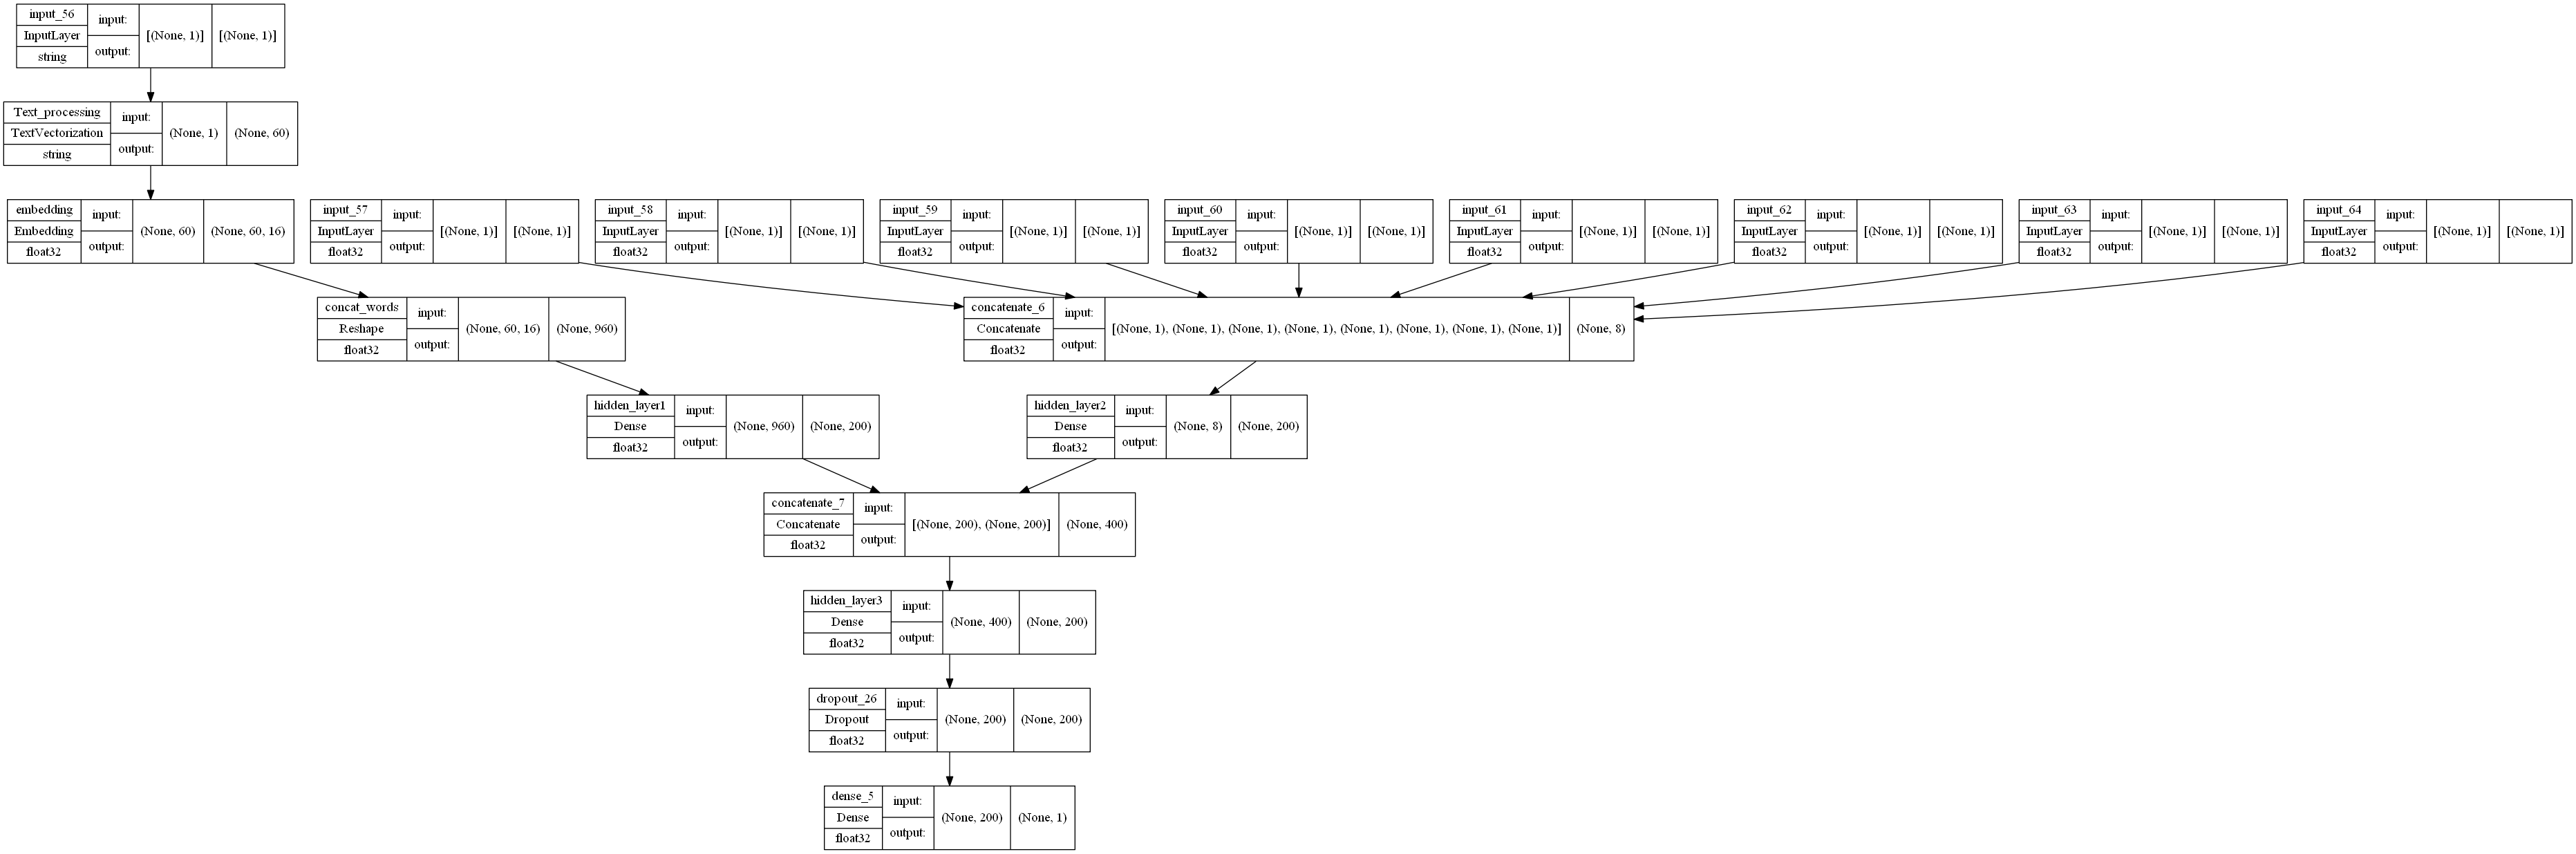

In [283]:
tf.keras.utils.plot_model(api_model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [258]:
train_encoded.shape

(103913, 8)

In [259]:
train_clean_data.shape

(103913, 13)

In [260]:
test_encoded.shape

(25978, 8)

In [261]:
test_clean_data.shape

(25978, 17)

In [262]:
text_train = train_clean_data['description_clean']
country_train = train_encoded['country']
province_train = train_encoded['province']
region_1_train = train_encoded['region_1']
region_2_train = train_encoded['region_2']
taster_name_train = train_encoded['taster_name']
variety_train = train_encoded['variety']
winery_train = train_encoded['winery']
price_train = train_encoded['price']

In [263]:
text_test = test_clean_data['description_clean']
country_test = test_encoded['country']
province_test = test_encoded['province']
region_1_test = test_encoded['region_1']
region_2_test= test_encoded['region_2']
taster_name_test = test_encoded['taster_name']
variety_test = test_encoded['variety']
winery_test = test_encoded['winery']
price_test = test_encoded['price']

In [284]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = api_model.fit(
    [text_train,country_train,province_train,region_1_train,region_2_train,taster_name_train,variety_train,winery_train,price_train],
    train_clean_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = ([text_test,country_test,province_test,region_1_test,region_2_test,taster_name_test,variety_test,winery_test,price_test], test_clean_data[target_col]))

Epoch 1/20
812/812 [==============================] - 16s 19ms/step - loss: 23.7253 - mean_squared_error: 6001.7588 - mean_absolute_error: 23.7253 - val_loss: 4.2774 - val_mean_squared_error: 27.1612 - val_mean_absolute_error: 4.2774
Epoch 2/20
812/812 [==============================] - 14s 17ms/step - loss: 9.0303 - mean_squared_error: 129.0683 - mean_absolute_error: 9.0303 - val_loss: 5.2085 - val_mean_squared_error: 34.7022 - val_mean_absolute_error: 5.2085
Epoch 3/20
812/812 [==============================] - 14s 18ms/step - loss: 8.3465 - mean_squared_error: 110.1498 - mean_absolute_error: 8.3465 - val_loss: 3.1712 - val_mean_squared_error: 14.6486 - val_mean_absolute_error: 3.1712
Epoch 4/20
812/812 [==============================] - 15s 18ms/step - loss: 7.8286 - mean_squared_error: 96.2309 - mean_absolute_error: 7.8286 - val_loss: 4.4392 - val_mean_squared_error: 24.4181 - val_mean_absolute_error: 4.4392
Epoch 5/20
812/812 [==============================] - 16s 20ms/step - loss

In [285]:
test_clean_data['api_prediction'] = api_model.predict([text_test,country_test,province_test,region_1_test,region_2_test,taster_name_test,variety_test,winery_test,price_test])

In [286]:
api_stats = calc_prediction_quality(test_clean_data, 'api_prediction', target_col)
api_stats

MSE    14.648619
MAE     3.171189
R2     -0.578338
dtype: float64

In [289]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, nlp_stats, nlp_all_stats, dnn_stats, concat_stats, lstm_stats, api_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','nlp','nlp_all', 'dnn','dnn_concat','lstm','functional_api'])
all_compared

,MSE,MAE,R2
baseline_1,9.364946,2.504136,-0.000035
baseline_2,8.950475,2.445987,0.044225
baseline_3,8.426780,2.356449,0.100147
regression_by_xgb,6.158211,1.876742,0.342396
nlp,3.165062,1.390200,0.656971
nlp_all,2.911302,1.328500,0.684474
dnn,2.965652,1.362010,0.680461
dnn_concat,3.096587,1.394272,0.666353
lstm,9.536721,2.480030,-0.027549
functional_api,14.648619,3.171189,-0.578338


In [290]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## **Final Conclusion**

We can see 

In [13]:
all_compared = pd.read_csv("data/all_models_compared.csv")
all_compared

,MSE,MAE,R2
0,9.364946,2.504136,-0.000035
1,8.950475,2.445987,0.044225
2,8.426780,2.356449,0.100147
3,6.158211,1.876742,0.342396
4,3.165062,1.390200,0.656971
5,2.911302,1.328500,0.684474
6,2.965652,1.362010,0.680461
7,3.096587,1.394272,0.666353
8,9.536721,2.480030,-0.027549
9,14.648619,3.171189,-0.578338


## **Final Conclusions**

We would expect that deep learning models result in better predictions. However we don't see this from the above table.

Hypthosis: maybe there is a problem with the data (encoded vs not encoded data) that should be further checked.

In [27]:
results = pd.read_csv("data/all_models_compared.csv")

In [28]:
results = results.assign(Model=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','nlp','nlp_all', 'dnn','dnn_concat','lstm','functional_api'])

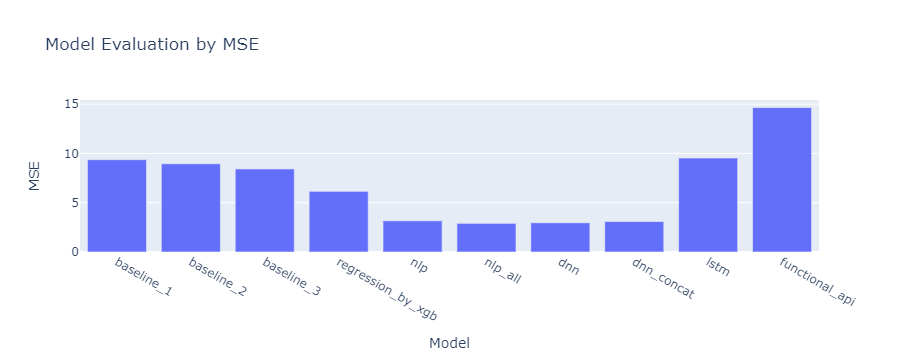

In [32]:
fig1 = px.bar(results, x = 'Model', y = 'MSE', title = 'Model Evaluation by MSE')
fig1.show()

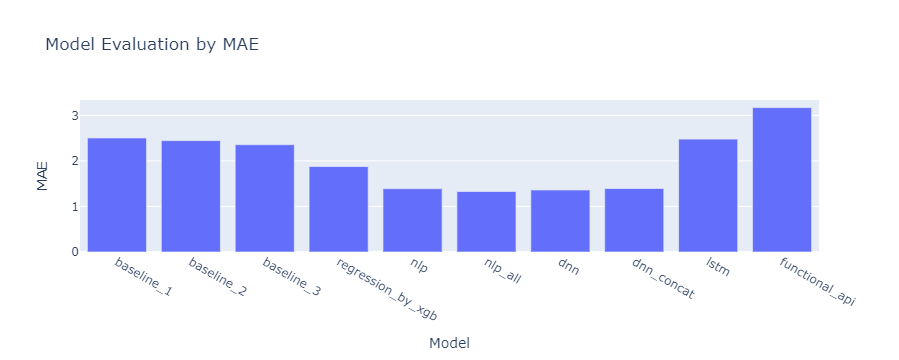

In [34]:
fig2 = px.bar(results, x = 'Model', y = 'MAE', title = 'Model Evaluation by MAE')
fig2.show()